## Work
1. 試改變 monitor "Validation Accuracy" 並比較結果
2. 調整 earlystop 的等待次數至 10, 25 並比較結果

In [5]:
import os
import keras
import matplotlib.pyplot as plt
%matplotlib inline

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [6]:
train, test = keras.datasets.cifar10.load_data()

In [7]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [8]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [9]:
from keras.layers import BatchNormalization

"""Code Here
    建立你的神經網路
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512,256,128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i,n_units in enumerate(num_neurons):
        if i ==0:
            x = keras.layers.Dense(units=n_units, activation='relu', name='hidden_layer'+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, activation='relu', name='hidden_layer'+str(i+1))(x)
            x = BatchNormalization()(x)
    out = keras.layers.Dense(units=output_units,activation="softmax", name="output")(x)        
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [16]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

PATIENCE = [5, 10, 25]

In [18]:
# 載入 Callbacks
"""Code Here
設定 callbacks: Earlystop
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
# 載入 Callbacks, 並將 monitor 設定為監控 validation loss
from keras.callbacks import EarlyStopping

results = {}
i =0
for pati in PATIENCE:
    
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with patience = %.6f." % (pati))
    
    #set earlystop
    earlystop = EarlyStopping(monitor="val_loss", patience=pati, verbose=1)
    
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[earlystop]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}
    i = i +1

Experiment with patience = 5.000000.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128

50000/50000 [==============================] - 6s 116us/step - loss: 1.2075 - acc: 0.5831 - val_loss: 1.4678 - val_acc: 0.4877
Epoch 15/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.1835 - acc: 0.5926 - val_loss: 1.4703 - val_acc: 0.4865
Epoch 16/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.1605 - acc: 0.6013 - val_loss: 1.4635 - val_acc: 0.4956
Epoch 17/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.1362 - acc: 0.6097 - val_loss: 1.4560 - val_acc: 0.4866
Epoch 18/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.1154 - acc: 0.6190 - val_loss: 1.4526 - val_acc: 0.4944
Epoch 19/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.0939 - acc: 0.6266 - val_loss: 1.4568 - val_acc: 0.4936
Epoch 20/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.0717 - acc: 0.6361 - val_loss: 1.4633 - val_acc: 0.4933
Epoch 21/25
50000/50000 [==============

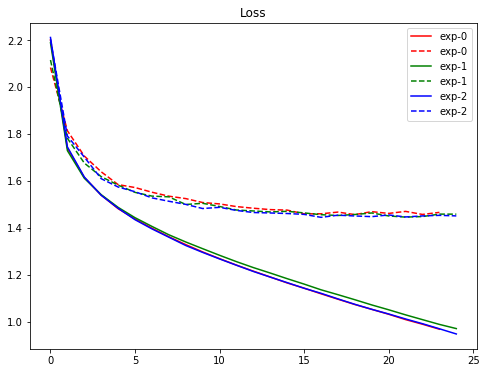

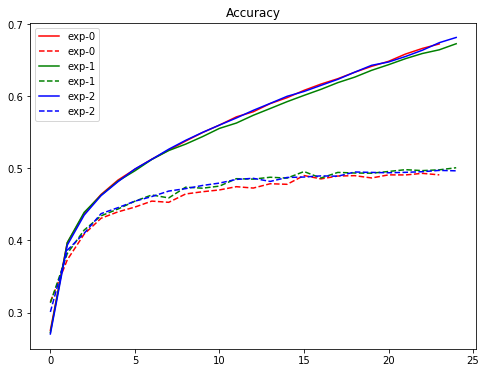

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k",
             "tab:orange","tab:purple","tab:brown","tab:pink","tab:gray","tab:cyan"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()